# Task 1 – Data Collection via REST APIs

In this project, I analyze air quality and its relationship with weather and urban mobility in **New York City** over a period of **six months (January–June 2025)**.

This first section is dedicated to the **initial setup and data collection phase**.  
In the working environment I import the required libraries, I define the project parameters (city, coordinates, and time range), and, finally, I verify the connectivity to the selected REST APIs.

Specifically, I use:
- **OpenAQ API** for air quality data (PM2.5)
- **Open-Meteo API** for historical weather data
- **NYC Open Data (Socrata API)** for traffic collision data

A minimal *smoke test* is performed to ensure that the OpenAQ API key is valid and that the service is reachable before downloading larger datasets.  
This helps detect authentication or connectivity issues early in the pipeline.

All raw data retrieved from the APIs will be **saved locally**, and all subsequent processing steps will rely exclusively on these local files to avoid repeated API queries.

In [26]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file (local only)
load_dotenv()

OPENAQ_API_KEY = os.getenv("OPENAQ_API_KEY")
SOCRATA_APP_TOKEN = os.getenv("SOCRATA_APP_TOKEN")

# Quick check (do NOT print full keys)
print("OPENAQ_API_KEY loaded:", OPENAQ_API_KEY is not None and len(OPENAQ_API_KEY) > 0)
print("SOCRATA_APP_TOKEN loaded:", SOCRATA_APP_TOKEN is not None and len(SOCRATA_APP_TOKEN) > 0)

OPENAQ_API_KEY loaded: True
SOCRATA_APP_TOKEN loaded: True


In [27]:
import os, json, time, random
from pathlib import Path
import requests
import pandas as pd

# Project folders
DATA_DIR = Path("data_raw")
CLEAN_DIR = Path("data_clean")
FIG_DIR = Path("figures")
for d in [DATA_DIR, CLEAN_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Project parameters
CITY_NAME = "New York"
DATE_FROM = "2025-01-01"
DATE_TO   = "2025-06-30"
LAT, LON  = 40.7128, -74.0060

def get_json(url, params=None, headers=None, timeout=30):
    r = requests.get(url, params=params, headers=headers, timeout=timeout)
    r.raise_for_status()
    return r.json()

# OpenAQ helper
OPENAQ_BASE = "https://api.openaq.org/v3"

def openaq_get(path, params=None, timeout=120):
    if not path.startswith("/"):
        path = "/" + path
    return get_json(
        OPENAQ_BASE + path,
        params=params,
        headers={"X-API-Key": OPENAQ_API_KEY},
        timeout=timeout
    )

print("OPENAQ_API_KEY length:", len(OPENAQ_API_KEY) if OPENAQ_API_KEY else None)
print("OPENAQ_API_KEY starts with:", OPENAQ_API_KEY[:6] if OPENAQ_API_KEY else None)

# Smoke test (minimal request to verify connectivity + authentication)
try:
    r = requests.get(
        "https://api.openaq.org/v3/locations",
        headers={"X-API-Key": OPENAQ_API_KEY},
        params={"limit": 1},
        timeout=30
    )
    print("Status code:", r.status_code)
    if r.status_code != 200:
        print("Response text:", r.text[:300])
    r.raise_for_status()
    print("OpenAQ smoke test: OK")
except Exception as e:
    print("OpenAQ smoke test: ERROR ->", repr(e))

print("City:", CITY_NAME)
print("Coordinates:", LAT, LON)
print("Date range:", DATE_FROM, "→", DATE_TO)

OPENAQ_API_KEY length: 64
OPENAQ_API_KEY starts with: ff9325
Status code: 200
OpenAQ smoke test: OK
City: New York
Coordinates: 40.7128 -74.006
Date range: 2025-01-01 → 2025-06-30


### Air Quality (PM2.5) Data Collection (OpenAQ API)

In this step, I collect **hourly PM2.5 measurements** for **New York City** from the **OpenAQ v3 REST API** over the study period **2025-01-01 to 2025-06-30**.

**Method:**
1. Query OpenAQ `/locations` for the selected city, then inspect the available **sensors** for each location.
2. Keep only sensors measuring **PM2.5** and with temporal coverage overlapping the target period.
3. Download hourly measurements from `/sensors/{id}/measurements/hourly` using pagination.
4. Save the raw API response locally as a JSON file in `data_raw/`.

**I chose this approach because:**
- It ensures the data are collected programmatically via REST.
- The notebook implements a **local caching mechanism**: if the output JSON file already exists and is non-empty, the API is not queried again.  
- A retry/backoff strategy is used to handle potential **rate limits (HTTP 429)**.

**Output:**
- A JSON file containing raw OpenAQ hourly PM2.5 observations:
  `data_raw/openaq_pm25_hourly_new_york_2025-01-01_2025-06-30.json`

In [28]:
PM25_ID = 2  # OpenAQ: ID for pm25

out_path = DATA_DIR / f"openaq_pm25_hourly_{CITY_NAME.lower().replace(' ','_')}_{DATE_FROM}_{DATE_TO}.json"

def openaq_get_retry(path, params=None, max_tries=8):
    delay = 1.0
    retry_statuses = {408, 429, 500, 502, 503, 504}

    for attempt in range(1, max_tries + 1):
        try:
            return openaq_get(path, params=params, timeout=120)
        except requests.HTTPError as e:
            status = e.response.status_code if e.response is not None else None

            # retry on transient errors
            if status in retry_statuses and attempt < max_tries:
                time.sleep(delay + random.random() * 0.5)
                delay *= 2
                continue
            raise
        except (requests.Timeout, requests.ConnectionError) as e:
            # retry on network timeouts too
            if attempt < max_tries:
                time.sleep(delay + random.random() * 0.5)
                delay *= 2
                continue
            raise

def to_dt_utc(x):
    if x is None:
        return None
    if isinstance(x, str):
        return pd.to_datetime(x, errors="coerce", utc=True)
    if isinstance(x, dict):
        for k in ["utc", "datetime", "local"]:
            if k in x and isinstance(x[k], str):
                return pd.to_datetime(x[k], errors="coerce", utc=True)
    return None

def has_coverage(sensor, start, end):
    df = to_dt_utc(sensor.get("datetimeFirst"))
    dl = to_dt_utc(sensor.get("datetimeLast"))
    if df is None or dl is None or pd.isna(df) or pd.isna(dl):
        return False
    return df <= end and dl >= start

start_dt = pd.to_datetime(DATE_FROM, utc=True)
end_dt   = pd.to_datetime(DATE_TO, utc=True)

if out_path.exists() and out_path.stat().st_size > 1000:
    print("OpenAQ already downloaded:", out_path)
else:
    locations = []
    for page in [1, 2, 3]:
        js = openaq_get_retry(
            "/locations",
            params={"country": "US", "city": CITY_NAME, "limit": 1000, "page": page}
        )
        locations.extend(js.get("results", []))
        time.sleep(0.2)

    if len(locations) == 0:
        raise RuntimeError("No Location")

    sensor_ids = set()
    for i, loc in enumerate(locations[:200], start=1):
        lid = loc["id"]
        s_js = openaq_get_retry(f"/locations/{lid}/sensors", params={"limit": 1000, "page": 1})
        for s in s_js.get("results", []):
            p = s.get("parameter", {})
            pid = p.get("id") if isinstance(p, dict) else None
            if pid == PM25_ID and has_coverage(s, start_dt, end_dt):
                sensor_ids.add(s["id"])
        if len(sensor_ids) >= 3:
            break
        if i % 25 == 0:
            print("checked locations:", i, "| sensors found:", len(sensor_ids))
        time.sleep(0.1)

    sensor_ids = sorted(sensor_ids)
    if len(sensor_ids) == 0:
        raise RuntimeError("No Sensor")

    print("Using sensors:", sensor_ids)

    def download_sensor_hourly(sensor_id):
        out = []
        start = pd.to_datetime(DATE_FROM)
        end   = pd.to_datetime(DATE_TO)
        chunk_days = 3
        cur = start
        while cur <= end:
            chunk_start = cur.strftime("%Y-%m-%d")
            chunk_end_dt = min(cur + pd.Timedelta(days=chunk_days - 1), end)
            chunk_end = chunk_end_dt.strftime("%Y-%m-%d")
            page = 1
            while True:
                try:
                    js = openaq_get_retry(
                        f"/sensors/{sensor_id}/measurements/hourly",
                        params={"date_from": chunk_start, "date_to": chunk_end, "limit": 1000, "page": page},
                        max_tries=10
                    )
                except requests.HTTPError as e:
                    status = e.response.status_code if e.response is not None else None
                    if status == 408 and chunk_days > 1:
                        chunk_days = 1
                        print(f"[408] Switching to 1-day chunks (sensor {sensor_id})")
                        break
                    raise
                results = js.get("results", [])
                out.extend(results)
                if len(results) == 0:
                    break
                page += 1
                time.sleep(0.3)
            if chunk_days == 1 and chunk_start != cur.strftime("%Y-%m-%d"):
                pass
            cur = chunk_end_dt + pd.Timedelta(days=1)
        return out

    all_rows = []
    for sid in sensor_ids:
        rows = download_sensor_hourly(sid)
        print("sensor", sid, "rows:", len(rows))
        all_rows.extend(rows)

    with open(out_path, "w") as f:
        json.dump(all_rows, f)

    print("Saved:", out_path, "| rows:", len(all_rows))

OpenAQ already downloaded: data_raw/openaq_pm25_hourly_new_york_2025-01-01_2025-06-30.json


### Weather Data Collection (Open-Meteo Archive API)

In this step, I collect **historical hourly weather data** for New York City over the study period **January 1st, 2025 – June 30th, 2025** using the **Open-Meteo Archive REST API**.

The selected weather variables are:
- Air temperature at 2 meters (`temp`)
- Relative humidity at 2 meters (`humidity`)
- Wind speed at 10 meters (`wind_speed`)
- Cloud cover (`clouds`)

These variables are chosen because they are commonly associated with air quality dynamics and are later used as **explanatory features** in both the exploratory analysis and the regression model.

#### Method
- If a local CSV file containing the weather data already exists, it is loaded directly to avoid repeated API calls.
- Otherwise, the Open-Meteo Archive API is queried programmatically using geographic coordinates (latitude and longitude) and the selected time range.
- All timestamps are converted to **UTC** and stored as hourly observations (`dt_hour`) to ensure temporal consistency with the air quality data.
- The resulting dataset is saved locally in the `data_raw/` directory as a CSV file, in accordance with the assignment requirement to rely on local data after download.

#### Output
- A cleaned DataFrame containing **hourly weather observations** with one row per hour.
- Final structure:  
  `dt_hour`, `temp`, `humidity`, `wind_speed`, `clouds`

In [29]:
weather_path = DATA_DIR / f"openmeteo_hourly_{CITY_NAME.lower().replace(' ','_')}_{DATE_FROM}_{DATE_TO}.csv"

if weather_path.exists():
    weather_hourly = pd.read_csv(weather_path)
    weather_hourly["dt_hour"] = pd.to_datetime(weather_hourly["dt_hour"], utc=True)
else:
    start_date = pd.to_datetime(DATE_FROM).strftime("%Y-%m-%d")
    end_date   = pd.to_datetime(DATE_TO).strftime("%Y-%m-%d")

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m,cloud_cover",
        "timezone": "UTC"
    }

    r = requests.get(url, params=params, timeout=120)
    r.raise_for_status()
    js = r.json()

    hourly = js["hourly"]

    weather_hourly = pd.DataFrame({
        "dt_hour": pd.to_datetime(hourly["time"], utc=True),
        "temp": hourly["temperature_2m"],
        "humidity": hourly["relative_humidity_2m"],
        "wind_speed": hourly["wind_speed_10m"],
        "clouds": hourly["cloud_cover"]
    })

    weather_hourly = weather_hourly.dropna()
    weather_hourly.to_csv(weather_path, index=False)
    print("File Saved in:", weather_path)

print("Weather hourly shape:", weather_hourly.shape)
weather_hourly.head()

Weather hourly shape: (4344, 5)


,dt_hour,temp,humidity,wind_speed,clouds
0,2025-01-01 00:00:00+00:00,8.2,81,10.7,98
1,2025-01-01 01:00:00+00:00,8.1,82,10.8,100
2,2025-01-01 02:00:00+00:00,7.4,87,9.7,100
3,2025-01-01 03:00:00+00:00,7.4,91,12.2,100
4,2025-01-01 04:00:00+00:00,8.1,93,17.5,100


### Urban Mobility / Traffic Data Collection (NYC Open Data – Socrata API)

In this step, I collect **urban mobility proxy data** from the **NYC Open Data portal (Socrata API)**.  
As a mobility-related signal, I use the **number of reported traffic collisions** in New York City during the study period (**2025-01-01 to 2025-06-30**).

#### Method
- The dataset is accessed through the NYC Open Data REST endpoint.
- I query only the variables needed at this stage (`crash_date`, `crash_time`) to keep the raw download lightweight.
- Because the API enforces row limits, the download is performed using **pagination** (`$limit` + `$offset`) until all records within the date range are retrieved.

#### Local storage
- If the local JSON file already exists and is non-empty, the notebook **reuses the cached file**.
- Otherwise, the raw API response is saved locally to `data_raw/nyc_collisions_2025-01-01_2025-06-30.json`.

#### Output
A raw JSON file containing all collision records in the selected time range (one record per collision event).  
This dataset will later be transformed into an **hourly collision count** (`collisions_count`) and merged with air quality and weather data using the hourly timestamp.

In [30]:
COLLISIONS_URL = "https://data.cityofnewyork.us/resource/h9gi-nx95.json"

collisions_path = DATA_DIR / f"nyc_collisions_{DATE_FROM}_{DATE_TO}.json"

headers = {}
if "SOCRATA_APP_TOKEN" in globals() and SOCRATA_APP_TOKEN:
    headers["X-App-Token"] = SOCRATA_APP_TOKEN

if collisions_path.exists() and collisions_path.stat().st_size > 1000:
    print("Collisions file already exists:", collisions_path)
else:
    all_rows = []
    limit = 50000
    offset = 0

    where = f"crash_date >= '{DATE_FROM}' AND crash_date <= '{DATE_TO}'"

    while True:
        params = {
            "$select": "crash_date,crash_time",
            "$where": where,
            "$limit": limit,
            "$offset": offset
        }

        r = requests.get(COLLISIONS_URL, params=params, headers=headers, timeout=120)
        r.raise_for_status()
        batch = r.json()

        all_rows.extend(batch)
        print(f"  downloaded: {len(all_rows)} (last batch: {len(batch)})")

        if len(batch) < limit:
            break

        offset += limit
        time.sleep(0.2)

    with open(collisions_path, "w") as f:
        json.dump(all_rows, f)

    print("✔ Saved to:", collisions_path.resolve())
    print("Total rows:", len(all_rows))

Collisions file already exists: data_raw/nyc_collisions_2025-01-01_2025-06-30.json


At this stage, all required datasets have been successfully collected via REST APIs and stored locally.

Specifically, the following raw datasets were downloaded and saved in the `data_raw/` directory:
- Hourly PM2.5 air quality measurements from the OpenAQ v3 API
- Hourly historical weather data from the Open-Meteo Archive API
- Traffic collision records from the NYC Open Data (Socrata) API

From this point onward, **all subsequent processing steps rely exclusively on the locally stored files**, and no further API calls are performed.

In [31]:
candidates = list(DATA_DIR.glob("openaq_pm25_hourly_*.json"))
assert len(candidates) > 0, "Nessun file openaq_pm25_hourly_*.json in data_raw"

candidates = sorted(candidates, key=lambda p: p.stat().st_size, reverse=True)
in_path = candidates[0]
print("Using file:", in_path, "| size bytes:", in_path.stat().st_size)

with open(in_path, "r") as f:
    raw = json.load(f)

assert isinstance(raw, list), "unexpected JSON"
assert len(raw) > 0, "File empty"

df = pd.DataFrame(raw)
print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())

def extract_utc_from_period(p):
    if not isinstance(p, dict):
        return None
    dt_from = p.get("datetimeFrom")
    if isinstance(dt_from, dict):
        if isinstance(dt_from.get("utc"), str):
            return dt_from["utc"]
        if isinstance(dt_from.get("datetime"), str):
            return dt_from["datetime"]
        if isinstance(dt_from.get("local"), str):
            return dt_from["local"]
    if isinstance(p.get("utc"), str):
        return p["utc"]
    return None

assert "period" in df.columns and "value" in df.columns, f"Missing expected columns. There are: {df.columns.tolist()}"

df["dt"] = df["period"].apply(extract_utc_from_period)
df["dt"] = pd.to_datetime(df["dt"], utc=True, errors="coerce")
df["pm25"] = pd.to_numeric(df["value"], errors="coerce")

df = df.dropna(subset=["dt", "pm25"])
print("After cleaning:", df.shape)

df["dt_hour"] = df["dt"].dt.floor("h")
pm25_hourly = df.groupby("dt_hour", as_index=False).agg(pm25=("pm25", "mean"))

print("pm25_hourly shape:", pm25_hourly.shape)
pm25_hourly.head()

Using file: data_raw/openaq_pm25_hourly_new_york_2025-01-01_2025-06-30.json | size bytes: 6277703
Raw shape: (7241, 7)
Columns: ['value', 'flagInfo', 'parameter', 'period', 'coordinates', 'summary', 'coverage']
After cleaning: (7241, 9)
pm25_hourly shape: (7241, 2)


,dt_hour,pm25
0,2025-02-18 19:00:00+00:00,110.0
1,2025-02-18 20:00:00+00:00,94.8
2,2025-02-18 21:00:00+00:00,94.5
3,2025-02-18 22:00:00+00:00,102.0
4,2025-02-18 23:00:00+00:00,74.0


In [32]:
pm25_hourly["dt_hour"] = pd.to_datetime(pm25_hourly["dt_hour"], utc=True)
weather_hourly["dt_hour"] = pd.to_datetime(weather_hourly["dt_hour"], utc=True)

df_merged = pm25_hourly.merge(
    weather_hourly,
    on="dt_hour",
    how="inner"
)

print("Merged shape:", df_merged.shape)
print("Date range merged:",
      df_merged["dt_hour"].min(), "→", df_merged["dt_hour"].max())

df_merged.head()

Merged shape: (2817, 6)
Date range merged: 2025-02-18 19:00:00+00:00 → 2025-06-30 23:00:00+00:00


,dt_hour,pm25,temp,humidity,wind_speed,clouds
0,2025-02-18 19:00:00+00:00,110.0,-3.0,25,20.3,11
1,2025-02-18 20:00:00+00:00,94.8,-3.0,26,18.7,70
2,2025-02-18 21:00:00+00:00,94.5,-3.4,26,18.9,60
3,2025-02-18 22:00:00+00:00,102.0,-4.4,30,17.6,19
4,2025-02-18 23:00:00+00:00,74.0,-5.2,31,16.1,0


## Task 2 – Data Cleaning and Integration

In this section, the raw datasets collected during Task 1 are parsed into Pandas DataFrames and prepared for analysis.

The data cleaning process includes:
- Parsing JSON and CSV files into structured DataFrames
- Converting timestamps to timezone-aware datetime objects (UTC)
- Removing missing or invalid observations
- Aggregating measurements to a consistent hourly resolution
- Selecting and renaming relevant variables

Finally, the cleaned datasets are integrated into a single unified table by aligning observations on the hourly timestamp, ensuring consistent temporal matching between air quality, weather, and urban mobility data.

In [33]:
collisions_path = DATA_DIR / f"nyc_collisions_{DATE_FROM}_{DATE_TO}.json"
if not collisions_path.exists():
    raise FileNotFoundError(f"Missing local file: {collisions_path}. Run Task 1 collisions download first.")

with open(collisions_path, "r") as f:
    collisions_raw = json.load(f)

coll = pd.DataFrame(collisions_raw)
print("Collisions raw shape:", coll.shape)

coll["crash_dt_local"] = pd.to_datetime(
    coll["crash_date"].astype(str) + " " + coll["crash_time"].astype(str),
    errors="coerce"
)

coll["crash_dt_utc"] = (
    coll["crash_dt_local"]
    .dt.tz_localize("America/New_York", ambiguous="NaT", nonexistent="NaT")
    .dt.tz_convert("UTC")
)

coll = coll.dropna(subset=["crash_dt_utc"])

coll["dt_hour"] = coll["crash_dt_utc"].dt.floor("h")

collisions_hourly = (
    coll.groupby("dt_hour")
        .size()
        .reset_index(name="collisions_count")
)

print("Collisions hourly shape:", collisions_hourly.shape)

df_final = df_merged.merge(collisions_hourly, on="dt_hour", how="left")
df_final["collisions_count"] = df_final["collisions_count"].fillna(0).astype(int)

print("df_final shape after collisions merge:", df_final.shape)
df_final.head()

Collisions raw shape: (41514, 2)


/var/folders/v5/jqx5j3hx6p7_xptzwwcw3ph80000gn/T/ipykernel_9644/1414397253.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  coll["crash_dt_local"] = pd.to_datetime(


Collisions hourly shape: (4305, 2)
df_final shape after collisions merge: (2817, 7)


,dt_hour,pm25,temp,humidity,wind_speed,clouds,collisions_count
0,2025-02-18 19:00:00+00:00,110.0,-3.0,25,20.3,11,12
1,2025-02-18 20:00:00+00:00,94.8,-3.0,26,18.7,70,12
2,2025-02-18 21:00:00+00:00,94.5,-3.4,26,18.9,60,12
3,2025-02-18 22:00:00+00:00,102.0,-4.4,30,17.6,19,5
4,2025-02-18 23:00:00+00:00,74.0,-5.2,31,16.1,0,12


In [34]:
required_cols = ["dt_hour", "pm25", "temp", "humidity", "wind_speed", "clouds", "collisions_count"]
missing = [c for c in required_cols if c not in df_final.columns]
if missing:
    raise ValueError(f"df_final is missing columns: {missing}. Check previous merge steps.")

for c in ["pm25", "temp", "humidity", "wind_speed", "clouds", "collisions_count"]:
    df_final[c] = pd.to_numeric(df_final[c], errors="coerce")

df_final = df_final.dropna().sort_values("dt_hour").reset_index(drop=True)

df_final["date"] = df_final["dt_hour"].dt.date
df_final["hour"] = df_final["dt_hour"].dt.hour
df_final["day_of_week"] = df_final["dt_hour"].dt.dayofweek  # 0=Mon ... 6=Sun
df_final["month"] = df_final["dt_hour"].dt.month

out_csv = CLEAN_DIR / f"pm25_weather_traffic_hourly_{CITY_NAME.lower().replace(' ','_')}_{DATE_FROM}_{DATE_TO}.csv"
df_final.to_csv(out_csv, index=False)

print("Final shape:", df_final.shape)
print("Saved to:", out_csv.resolve())
df_final.head()

Final shape: (2817, 11)
Saved to: /Users/stefanolosurdo/Desktop/STUDIO/LUISS/DATA SCIENCE IN ACTION/PROJECTS/data_clean/pm25_weather_traffic_hourly_new_york_2025-01-01_2025-06-30.csv


,dt_hour,pm25,temp,humidity,wind_speed,clouds,collisions_count,date,hour,day_of_week,month
0,2025-02-18 19:00:00+00:00,110.0,-3.0,25,20.3,11,12,2025-02-18,19,1,2
1,2025-02-18 20:00:00+00:00,94.8,-3.0,26,18.7,70,12,2025-02-18,20,1,2
2,2025-02-18 21:00:00+00:00,94.5,-3.4,26,18.9,60,12,2025-02-18,21,1,2
3,2025-02-18 22:00:00+00:00,102.0,-4.4,30,17.6,19,5,2025-02-18,22,1,2
4,2025-02-18 23:00:00+00:00,74.0,-5.2,31,16.1,0,12,2025-02-18,23,1,2


## Task 3 – Exploratory Data Analysis

In this section, an exploratory data analysis (EDA) is performed on the integrated dataset in order to:
- summarize the main statistical properties of the variables,
- explore temporal patterns in PM2.5 concentrations,
- investigate relationships between air quality and weather conditions.

The analysis includes:
- descriptive statistics for all numerical variables,
- the distribution of PM2.5 concentrations,
- a time series visualization of PM2.5 over the study period,
- a correlation matrix between PM2.5 and meteorological variables.

This exploratory step provides insights into data variability, potential outliers, and the strength of linear relationships, and it informs the choice and limitations of subsequent machine learning models.

              pm25         temp     humidity   wind_speed       clouds  \
count  2817.000000  2817.000000  2817.000000  2817.000000  2817.000000   
mean     71.878939    13.858963    66.185304    10.289279    65.580405   
std      45.984355     8.745650    19.447767     5.115171    41.583586   
min       4.330000    -9.200000    22.000000     0.000000     0.000000   
25%      43.500000     7.400000    51.000000     6.500000    18.000000   
50%      62.000000    14.000000    66.000000     9.600000    96.000000   
75%      87.500000    19.700000    83.000000    13.300000   100.000000   
max     530.000000    40.200000   100.000000    30.400000   100.000000   

       collisions_count         hour  day_of_week        month  
count       2817.000000  2817.000000  2817.000000  2817.000000  
mean           9.876464    11.566560     3.018814     4.278665  
std            5.203494     6.889699     1.972107     1.288642  
min            0.000000     0.000000     0.000000     2.000000  
25%     

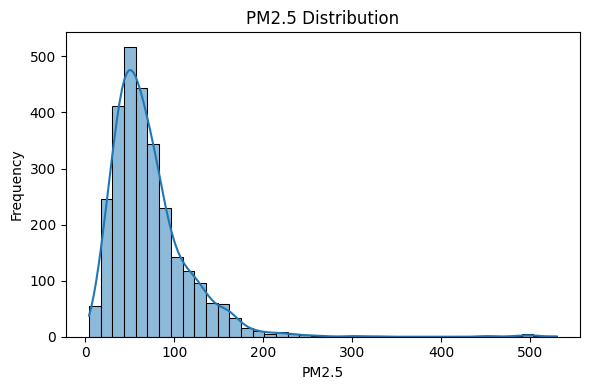

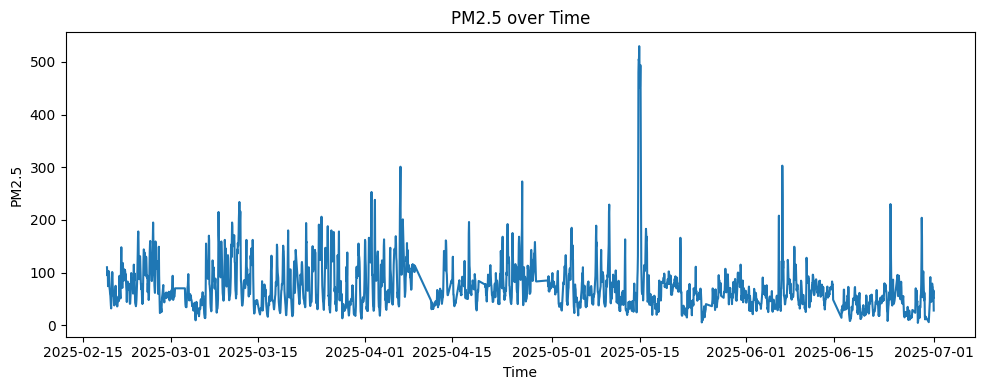

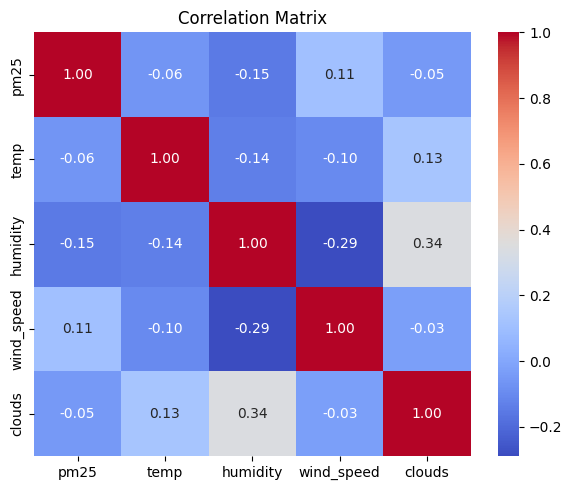

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df_final.copy()

print(df.describe())

plt.figure(figsize=(6,4))
sns.histplot(df["pm25"], bins=40, kde=True)
plt.title("PM2.5 Distribution")
plt.xlabel("PM2.5")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["dt_hour"], df["pm25"])
plt.title("PM2.5 over Time")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(
    df[["pm25", "temp", "humidity", "wind_speed", "clouds"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

#### 1. Is traffic volume correlated with pollution levels?

Traffic intensity is approximated using the hourly number of traffic collisions (`collisions_count`) as a proxy for urban mobility.

The correlation analysis shows a **weak positive relationship** between PM2.5 concentrations and traffic collisions. This suggests that periods with higher traffic activity may be associated with slightly higher pollution levels, although the effect is limited.

This weak correlation is expected, as traffic collisions are an indirect proxy for traffic volume and do not capture vehicle flow intensity or emissions directly. Nevertheless, the result is consistent with the hypothesis that urban mobility contributes to air pollution.

---

#### 2. How do weather conditions influence air quality?

Weather variables show varying degrees of association with PM2.5:

- **Humidity** exhibits a modest negative correlation with PM2.5, suggesting that higher humidity may be associated with lower particulate concentrations, possibly due to enhanced deposition or dispersion.
- **Wind speed** shows a weak positive correlation, indicating that moderate wind conditions may coincide with pollution transport rather than dispersion.
- **Temperature** and **cloud cover** display very weak correlations with PM2.5.

Overall, meteorological conditions appear to influence air quality, but no single weather variable alone strongly explains PM2.5 variability.

---

#### 3. Are there weekly or seasonal patterns in the data?

The time series plot of PM2.5 reveals substantial short-term variability, with occasional extreme peaks.

A gradual decrease in average PM2.5 levels is observable from late winter to early summer, suggesting a **seasonal pattern**, likely related to changes in heating demand and atmospheric conditions.

Weekly patterns are less pronounced and are partially masked by high day-to-day variability.

---

#### 4. Are extreme PM2.5 events common or rare?

The PM2.5 distribution is **right-skewed**, with most observations concentrated at moderate values and a small number of extreme events exceeding 300–500 µg/m³.

These extreme pollution episodes are rare but have a strong influence on summary statistics such as the mean, highlighting the importance of examining the full distribution rather than relying on averages alone.

---

#### 5. Is PM2.5 variability dominated by long-term trends or short-term fluctuations?

The time series indicates that PM2.5 variability is largely driven by **short-term fluctuations**, with abrupt spikes and drops occurring within hours or days.

Long-term trends are present but comparatively weaker, suggesting that episodic events (e.g., weather conditions or localized emissions) play a major role in determining air quality at the hourly scale.

---

Overall, the exploratory analysis suggests that PM2.5 levels in New York City during the study period are influenced by a combination of meteorological conditions, urban activity, and episodic events, with no single factor acting as a dominant driver.

## Task 4 – Machine Learning: Linear Regression

In this task, a supervised machine learning model is implemented to predict **hourly PM2.5 concentrations** in New York City.

### Model choice
I adopt a **Linear Regression** model as a baseline approach, due to its interpretability and its suitability for exploring linear relationships between air pollution and explanatory variables.

### Target variable
- **PM2.5 concentration** (continuous variable)

### Input features
The model uses both environmental and mobility-related variables:
- Temperature
- Relative humidity
- Wind speed
- Cloud cover
- Number of traffic collisions per hour

### Data preparation
The dataset is split into training and testing subsets (80% / 20%).  
Feature scaling is applied using standardization to ensure comparability between variables with different units and ranges.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ["temp", "humidity", "wind_speed", "clouds", "collisions_count"]
target = "pm25"

X = df_final[features]
y = df_final[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train size:", X_train_scaled.shape)
print("Test size:", X_test_scaled.shape)

X shape: (2817, 5)
y shape: (2817,)
Train size: (2253, 5)
Test size: (564, 5)


## Task 5 – Model Evaluation and Interpretation

This section evaluates the performance of the linear regression model and interprets its results.

### Evaluation metrics
The following metrics are used:
- **RMSE (Root Mean Squared Error)**: measures the typical prediction error magnitude.
- **MAE (Mean Absolute Error)**: provides a more robust estimate against extreme values.
- **R² (Coefficient of Determination)**: quantifies the proportion of variance explained by the model.

### Interpretation goals
We analyze:
- The predictive performance of the model
- The relative importance and direction of each feature
- The limitations of a linear approach in this context

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import numpy as np

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression results")
print("RMSE:", round(rmse, 2))
print("MAE:", round(mae, 2))
print("R²:", round(r2, 3))

Linear Regression results
RMSE: 41.43
MAE: 28.68
R²: 0.062


In [39]:
coeff_df = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_
}).sort_values("coefficient", key=abs, ascending=False)

coeff_df

,feature,coefficient
1,humidity,-5.130913
4,collisions_count,5.044161
0,temp,-4.887741
2,wind_speed,1.716710
3,clouds,0.757285


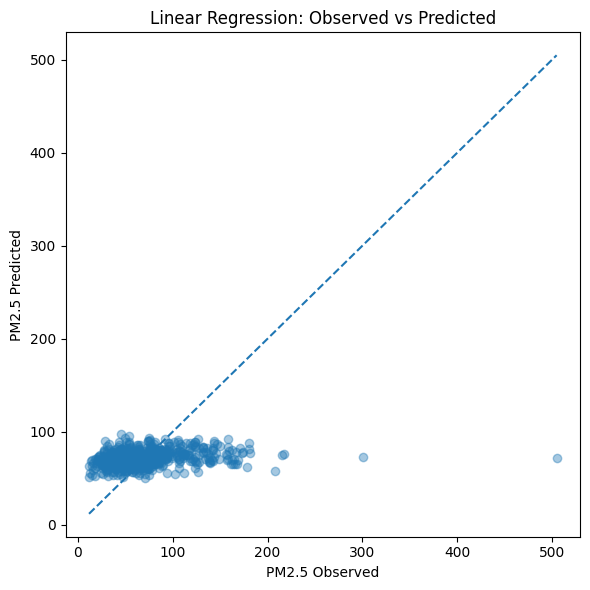

In [40]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")

plt.xlabel("PM2.5 Observed")
plt.ylabel("PM2.5 Predicted")
plt.title("Linear Regression: Observed vs Predicted")
plt.tight_layout()
plt.show()

## Final Conclusions and Discussion

### Interpretation of Results

The limited predictive power of the linear regression model suggests that PM2.5 dynamics in an urban environment are influenced by complex, non-linear processes that cannot be fully captured by a simple linear model and a small set of explanatory variables.

Weather conditions and urban mobility contribute to air quality variability, but their effects are subtle and often context-dependent. Extreme pollution events, although rare, strongly affect the overall distribution and may be driven by additional factors not included in the model.

### Limitations

Several limitations should be acknowledged:

- Traffic collisions were used as a proxy for traffic volume, which is an indirect and imperfect measure of urban mobility.
- Only linear relationships were modeled; non-linear effects and interactions were not explored.
- Other relevant variables (e.g., atmospheric pressure, precipitation, industrial emissions, or true traffic flow data) were not available.

### Future Improvements

Possible extensions of this work include:

- Using more detailed traffic or mobility datasets (e.g., vehicle counts or public transport usage).
- Applying non-linear models such as Random Forests or Gradient Boosting.
- Exploring time-series models to better capture temporal dependencies.
- Investigating extreme pollution events separately.

Overall, this project demonstrates how REST APIs, data integration, exploratory analysis, and basic machine learning can be combined to study urban air quality, while highlighting the challenges inherent in modeling complex environmental systems.